# Step 1: Preprocessing and Visualization with Scanpy

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

# Load DNA data
df = pd.read_csv("TCGA_BRCA_DNA.csv", index_col=0)

# Separate labels and features
labels = df["stage"]
features = df.drop(columns=["stage"])

# Remove all-zero features
features = features.loc[:, (features != 0).any(axis=0)]

# Filter out samples without stage labels
valid_idx = labels.notna()
features = features.loc[valid_idx]
labels = labels.loc[valid_idx]

# Construct AnnData object for Scanpy
adata = sc.AnnData(features)
adata.obs["stage"] = labels

# Standard scaling (mean=0, std=1)
sc.pp.scale(adata)

# Run PCA
sc.tl.pca(adata, svd_solver='arpack')

# Plot PCA colored by stage
sc.pl.pca(adata, color="stage", save="_stage.png", show=True)


# Step 2: Classification with MLP (Baseline Model)
## Train and evaluate a Multi-Layer Perceptron on preprocessed DNA features

Remaining number of features: 16650
✅ Classification Report (MLP Model):
              precision    recall  f1-score   support

     Stage I       0.07      0.03      0.04        32
    Stage II       0.67      0.67      0.67       111
   Stage III       0.30      0.45      0.36        42
    Stage IV       0.00      0.00      0.00         4

    accuracy                           0.50       189
   macro avg       0.26      0.29      0.27       189
weighted avg       0.47      0.50      0.48       189



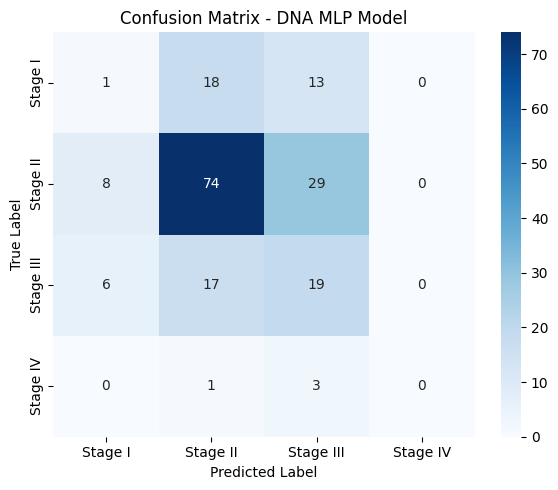

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load DNA data
df = pd.read_csv("TCGA_BRCA_DNA.csv", index_col=0)

# Separate labels and features
labels = df["stage"]
features = df.drop(columns=["stage"])

# Remove features that are entirely zero
features = features.loc[:, (features != 0).any(axis=0)]
print(f"Remaining number of features: {features.shape[1]}")

# Encode stage labels into integers
stage_mapping = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
y = labels.map(stage_mapping)
X = features

# Drop samples with missing labels
valid_idx = y.notna()
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# Split into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define and train MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = mlp_model.predict(X_test_scaled)

# Evaluation report
print("✅ Classification Report (MLP Model):")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Stage I", "Stage II", "Stage III", "Stage IV"],
    zero_division=0  
))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Stage I", "Stage II", "Stage III", "Stage IV"],
            yticklabels=["Stage I", "Stage II", "Stage III", "Stage IV"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DNA MLP Model")
plt.tight_layout()
plt.show()

# Step 3: Classification with Random Forest (Baseline)
## Train and evaluate a Random Forest classifier on DNA copy number data

✅ Classification Report (Random Forest):
              precision    recall  f1-score   support

     Stage I       0.50      0.03      0.06        32
    Stage II       0.60      0.94      0.73       111
   Stage III       0.54      0.17      0.25        42
    Stage IV       0.00      0.00      0.00         4

    accuracy                           0.59       189
   macro avg       0.41      0.28      0.26       189
weighted avg       0.56      0.59      0.50       189



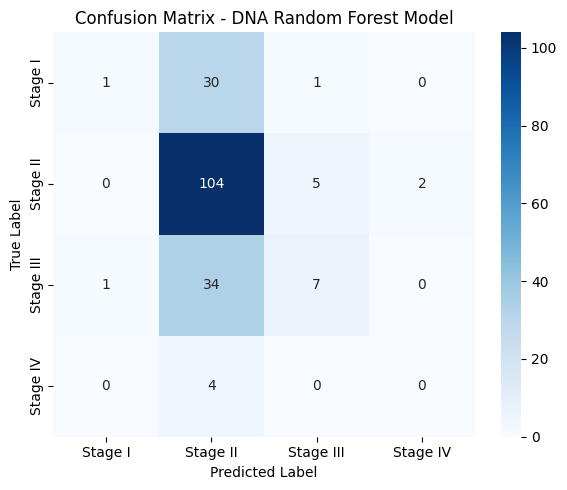

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load DNA dataset
df = pd.read_csv("TCGA_BRCA_DNA.csv", index_col=0)

# Separate labels and features
labels = df["stage"]
features = df.drop(columns=["stage"])

# Encode stage labels as integers
stage_mapping = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
y = labels.map(stage_mapping)
X = features

# Remove samples without valid stage labels
valid_idx = y.notna()
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Train Random Forest classifier
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("✅ Classification Report (Random Forest):")
print(classification_report(
    y_test,
    y_pred,
    target_names=["Stage I", "Stage II", "Stage III", "Stage IV"]
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Stage I", "Stage II", "Stage III", "Stage IV"],
            yticklabels=["Stage I", "Stage II", "Stage III", "Stage IV"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DNA Random Forest Model")
plt.tight_layout()
plt.show()


# Step 4: Feature Extraction with Autoencoder and Classification with MLP
## Train an autoencoder to compress DNA features, then use the encoded
## representation to train a simple MLP classifier for cancer stage prediction.

Remaining number of features: 16650
🔧 Pretraining Autoencoder...
Epoch 1, Loss: 11.9023
Epoch 2, Loss: 11.5159
Epoch 3, Loss: 11.0430
Epoch 4, Loss: 10.9934
Epoch 5, Loss: 11.0025
Epoch 6, Loss: 10.9489
Epoch 7, Loss: 10.7958
Epoch 8, Loss: 10.7301
Epoch 9, Loss: 10.6284
Epoch 10, Loss: 10.5142
Epoch 11, Loss: 10.3013
Epoch 12, Loss: 10.2693
Epoch 13, Loss: 10.1434
Epoch 14, Loss: 10.0263
Epoch 15, Loss: 9.8294
Epoch 16, Loss: 9.7095
Epoch 17, Loss: 9.5662
Epoch 18, Loss: 9.5149
Epoch 19, Loss: 9.2587
Epoch 20, Loss: 9.1536
Epoch 21, Loss: 8.9726
Epoch 22, Loss: 8.8607
Epoch 23, Loss: 8.6688
Epoch 24, Loss: 8.6079
Epoch 25, Loss: 8.3598
Epoch 26, Loss: 8.2542
Epoch 27, Loss: 8.2418
Epoch 28, Loss: 8.1389
Epoch 29, Loss: 8.1046
Epoch 30, Loss: 7.9516
🧠 Training classifier...
Epoch 1, Loss: 32.6737
Epoch 2, Loss: 28.0404
Epoch 3, Loss: 25.8043
Epoch 4, Loss: 24.9075
Epoch 5, Loss: 23.8972
Epoch 6, Loss: 23.1685
Epoch 7, Loss: 22.7552
Epoch 8, Loss: 22.1991
Epoch 9, Loss: 21.6669
Epoch 10

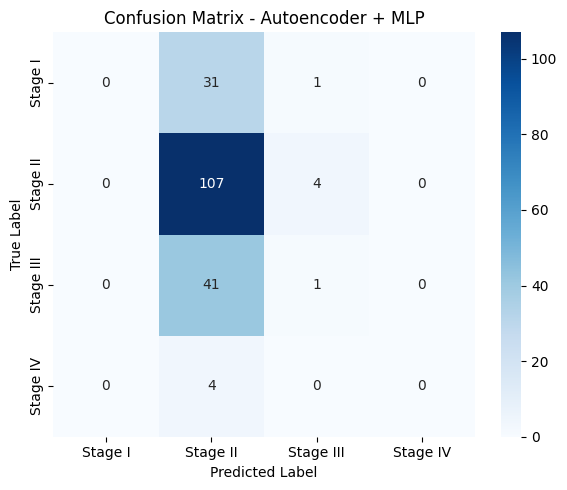

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1. Load and preprocess data
df = pd.read_csv("TCGA_BRCA_DNA.csv", index_col=0)

labels = df["stage"]
features = df.drop(columns=["stage"])

# Remove all-zero features
features = features.loc[:, (features != 0).any(axis=0)]
print(f"Remaining number of features: {features.shape[1]}")

# Encode stage labels
stage_mapping = {
    "Stage I": 1,
    "Stage II": 2,
    "Stage III": 3,
    "Stage IV": 4
}
y = labels.map(stage_mapping)
X = features

# Remove samples with missing labels
valid_idx = y.notna()
X = X.loc[valid_idx]
y = y.loc[valid_idx]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Data loader for autoencoder pretraining
train_loader = DataLoader(TensorDataset(X_train_tensor, X_train_tensor), batch_size=64, shuffle=True)

# 2. Define Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # bottleneck layer
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

autoencoder = Autoencoder(input_dim=X_train.shape[1])
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 3. Pretrain Autoencoder
print("🔧 Pretraining Autoencoder...")
for epoch in range(30):
    autoencoder.train()
    total_loss = 0
    for batch_x, _ in train_loader:
        recon = autoencoder(batch_x)
        loss = criterion(recon, batch_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# 4. Encode features and define classifier
autoencoder.eval()
with torch.no_grad():
    X_train_encoded = autoencoder.encoder(X_train_tensor)
    X_test_encoded = autoencoder.encoder(X_test_tensor)

# Define simple MLP classifier
classifier = nn.Sequential(
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 4),  # 4 output classes
)

criterion_cls = nn.CrossEntropyLoss()
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-3)

train_loader_cls = DataLoader(TensorDataset(X_train_encoded, y_train_tensor), batch_size=32, shuffle=True)

# 5. Train classifier
print("🧠 Training classifier...")
for epoch in range(30):
    classifier.train()
    total_loss = 0
    for x_batch, y_batch in train_loader_cls:
        logits = classifier(x_batch)
        loss = criterion_cls(logits, y_batch - 1)  # Adjust class index to start from 0
        optimizer_cls.zero_grad()
        loss.backward()
        optimizer_cls.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# 6. Evaluate on test set
classifier.eval()
with torch.no_grad():
    y_pred_logits = classifier(X_test_encoded)
    y_pred = torch.argmax(y_pred_logits, dim=1) + 1  # Convert back to 1–4 labels

# Classification report
print("✅ Classification Report (Autoencoder + MLP):")
print(classification_report(
    y_test,
    y_pred.numpy(),
    target_names=["Stage I", "Stage II", "Stage III", "Stage IV"],
    zero_division=0
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred.numpy())
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Stage I", "Stage II", "Stage III", "Stage IV"],
            yticklabels=["Stage I", "Stage II", "Stage III", "Stage IV"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Autoencoder + MLP")
plt.tight_layout()
plt.show()